In [2]:
# Librerias utilizadas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import warnings

## Importación de datos

In [3]:
csv_names  = ['df_DHCMA', 'df_CHG', 'df_CHGUADIANA',
            'df_CHS', 'df_DHGB', 'df_DHTOP']
path = '..\\DATA\\'
keys_names = ['Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas', 'Cuenca hidrográfica del Guadalquivir', 'Cuenca hidrográfica del Guadiana',
              'Cuenca hidrográfica del Segura', 'Demarcación Hidrográfica Guadalete-Barbate', 'Demarcación Hidrográfica Tinto, Odiel y Piedras']
df_dict = {key: pd.read_csv(path+value+'.csv', sep=',', encoding='ISO-8859-1')
           for key, value in zip(keys_names, csv_names)}

### Procesado de datos de entrada

In [4]:
# Función de creación de dataset sequencial con arrays de valores input/output
# Este dataset tiene la estructura adecuada para los datos de entrada
# en la red neuronal
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size)]
        after_window = obs.iloc[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [5]:
# Creación del dataset de indice IESP
iesp_dict =  {key: value['IESP']
           for key, value in df_dict.items()}

# Eliminación valores vacios iniciales
for key, df in iesp_dict.items():
    iesp_dict[key] = df.dropna(how='all')   


In [6]:
# Separación en conjunto de entrenamiento y de prueba
# Los datos de prueba empiezan a partir de 2011
iesp_train_dict, iesp_test_dict = {}, {}
for key, df in iesp_dict.items():
    df_train, df_test = train_test_split(df, test_size=0.13, shuffle=False)
    iesp_train_dict[key] = df_train
    iesp_test_dict[key] = df_test

In [7]:
# Cálculo de datasets sequenciales
sequence_size = 10
X_train_dict, y_train_dict, X_test_dict,y_test_dict = {}, {}, {}, {}

for key, df in iesp_train_dict.items():
    X_train,y_train = to_sequences(sequence_size, df)
    X_train_dict[key] = X_train
    y_train_dict[key] = y_train

for key, df in iesp_test_dict.items():
    X_test,y_test = to_sequences(sequence_size, df)
    X_test_dict[key] = X_test
    y_test_dict[key] = y_test
    
print("Dimensiones del training set: {}".format(X_train_dict[keys_names[0]].shape))
print("Dimensiones del test set: {}".format(X_test_dict[keys_names[0]].shape))

Dimensiones del training set: (846, 10, 1)
Dimensiones del test set: (118, 10, 1)


# Definición del modelo

In [8]:
def create_model(n_nodes=20, optimizer='adam', activation='relu'):
    # Arquitectura del modelo
    model = Sequential()
    model.add(LSTM(n_nodes, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    return model

#  Early stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

### GRID SEARCH busqueda mejores parámetros

In [9]:
# Transformación del modelo para aplicar grid search
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0, activation='relu', n_nodes=20)

# Parámetros de búsqueda
param_grid = {
    'n_nodes': [10,20, 50],
    'epochs': [50, 100],
    'batch_size' : [5,10,20],
    'optimizer' : ['SGD', 'adam'], 
    'activation' : ['relu', 'tanh']
}


# Se ignoran avisos de ejecución del grid search
warnings.simplefilter("ignore")

# Cálculo de grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=8)
grid_result_dict = {}
for key in iesp_train_dict.keys():
    grid_result_dict[key] = grid.fit(X_train_dict[key], y_train_dict[key], callbacks=[es], shuffle=False, validation_data=(
        X_test_dict[key], y_test_dict[key])
    )
    print(key)
    print("Best: %f using %s" % (grid_result_dict[key].best_score_, grid_result_dict[key].best_params_))
    print('')

Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas
Best: 0.654304 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 20, 'optimizer': 'SGD'}

Cuenca hidrográfica del Guadalquivir
Best: 0.601250 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 50, 'optimizer': 'adam'}

Cuenca hidrográfica del Guadiana
Best: 0.696245 using {'activation': 'relu', 'batch_size': 20, 'epochs': 100, 'n_nodes': 50, 'optimizer': 'SGD'}

Cuenca hidrográfica del Segura
Best: 0.733901 using {'activation': 'relu', 'batch_size': 10, 'epochs': 100, 'n_nodes': 20, 'optimizer': 'SGD'}

Demarcación Hidrográfica Guadalete-Barbate
Best: 0.534668 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100, 'n_nodes': 50, 'optimizer': 'adam'}

Demarcación Hidrográfica Tinto, Odiel y Piedras
Best: 0.583201 using {'activation': 'relu', 'batch_size': 5, 'epochs': 50, 'n_nodes': 20, 'optimizer': 'adam'}



# Entrenamiento del modelo

In [10]:
model_history_dict = {}

for key in iesp_train_dict.keys():
    model = create_model(grid_result_dict[key].best_params_['n_nodes'], grid_result_dict[key].best_params_[
                         'optimizer'], grid_result_dict[key].best_params_['activation'])

    model_history_dict[key] = model.fit(X_train_dict[key], y_train_dict[key], epochs=grid_result_dict[key].best_params_['epochs'],
        batch_size=grid_result_dict[key].best_params_['batch_size'],
        validation_data=(
        X_test_dict[key], y_test_dict[key]), verbose=2, shuffle=False, callbacks=[es]
        )

Epoch 1/50
170/170 - 2s - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0050 - val_mse: 0.0050 - 2s/epoch - 11ms/step
Epoch 2/50
170/170 - 0s - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0043 - val_mse: 0.0043 - 468ms/epoch - 3ms/step
Epoch 3/50
170/170 - 0s - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0040 - val_mse: 0.0040 - 464ms/epoch - 3ms/step
Epoch 4/50
170/170 - 0s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0038 - val_mse: 0.0038 - 459ms/epoch - 3ms/step
Epoch 5/50
170/170 - 0s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0036 - val_mse: 0.0036 - 458ms/epoch - 3ms/step
Epoch 6/50
170/170 - 0s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0035 - val_mse: 0.0035 - 466ms/epoch - 3ms/step
Epoch 7/50
170/170 - 0s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0033 - val_mse: 0.0033 - 465ms/epoch - 3ms/step
Epoch 8/50
170/170 - 0s - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0033 - val_mse: 0.0033 - 465ms/epoch - 3ms/step
Epoch 9/50
170/170 - 0s - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0032 - val_mse:

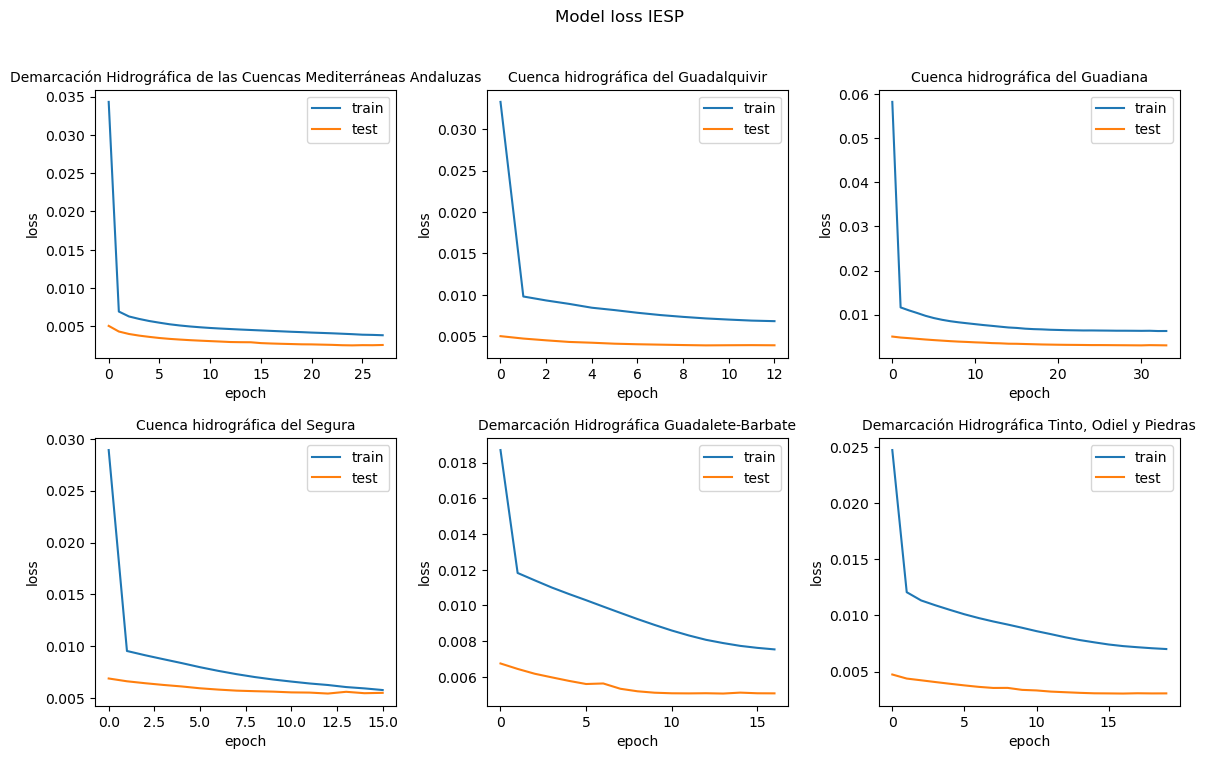

In [11]:
# Resumen del entrenamiento
n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(14,8))
fig.suptitle('Model loss IESP')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, (key, value) in enumerate(model_history_dict.items()):
    if i<n_cols:
        ax[0, i].plot(value.history['loss'])
        ax[0, i].plot(value.history['val_loss'])
        ax[0, i].set_title(key, fontsize=10)
        ax[0, i].set_ylabel('loss')
        ax[0, i].set_xlabel('epoch')
        ax[0, i].legend(['train', 'test'], loc='upper right')
    else:
        ax[1, i-n_cols].plot(value.history['loss'])
        ax[1, i-n_cols].plot(value.history['val_loss'])
        ax[1, i-n_cols].set_title(key, fontsize=10)
        ax[1, i-n_cols].set_ylabel('loss')
        ax[1, i-n_cols].set_xlabel('epoch')
        ax[1, i-n_cols].legend(['train', 'test'], loc='upper right')

# Evaluación del modelo

In [12]:
test_score_values = []
for key in iesp_dict.keys():
    print('Evaluación '+ key)
    train_prediction = model.predict(X_train_dict[key], verbose=0)
    test_prediction = model.predict(X_test_dict[key], verbose=0)
    train_score = model.evaluate(X_train_dict[key], y_train_dict[key], verbose=0)
    test_score = model.evaluate(X_test_dict[key], y_test_dict[key], verbose=0)
    test_score_values.append(test_score[0])
    print('Train score: {} MSE'.format(train_score[0]))
    print('Test score: {} MSE'.format(test_score[0]))
    print('')

mean_test_score = sum(test_score_values) / len(test_score_values)
print('LSTM IESP Mean Test score: {} MSE'.format(mean_test_score))

Evaluación Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas
Train score: 0.00335152936168015 MSE
Test score: 0.0020398516207933426 MSE

Evaluación Cuenca hidrográfica del Guadalquivir
Train score: 0.006260967813432217 MSE
Test score: 0.0037689090240746737 MSE

Evaluación Cuenca hidrográfica del Guadiana
Train score: 0.006452022586017847 MSE
Test score: 0.0029135802760720253 MSE

Evaluación Cuenca hidrográfica del Segura
Train score: 0.004971375223249197 MSE
Test score: 0.003678839420899749 MSE

Evaluación Demarcación Hidrográfica Guadalete-Barbate
Train score: 0.00726283248513937 MSE
Test score: 0.004661184269934893 MSE

Evaluación Demarcación Hidrográfica Tinto, Odiel y Piedras
Train score: 0.006592539604753256 MSE
Test score: 0.003073811298236251 MSE

LSTM IESP Mean Test score: 0.0033560293183351555 MSE


# Visualización de la predicción

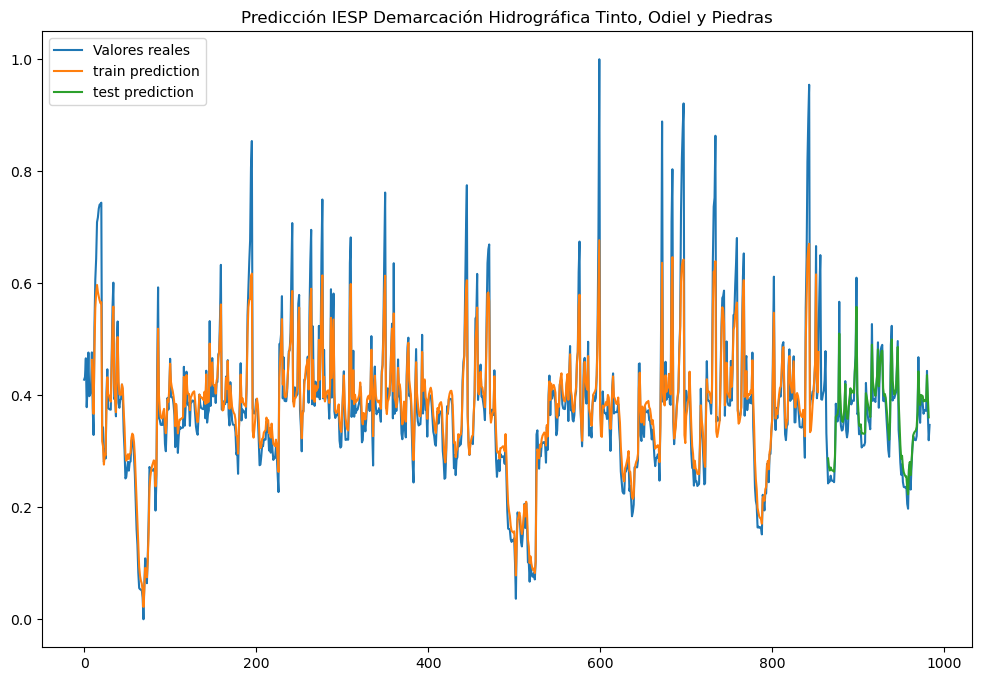

In [26]:
# Gráfica con los valores reales frente a los datos de predicción
# Se usa como ejemplo la predicción de la Demarcación Hidrográfica Tinto, Odiel y Piedras
plt.figure(figsize=(12, 8))
train_stamp = np.arange(sequence_size-1, sequence_size + X_train_dict[keys_names[5]].shape[0]-1)
test_stamp = np.arange(2 * sequence_size-1 + X_train_dict[keys_names[5]].shape[0], len(iesp_dict[keys_names[5]])-1)
plt.plot(iesp_dict[keys_names[5]], label='Valores reales')
plt.plot(train_stamp, train_prediction, label='train prediction')
plt.plot(test_stamp, test_prediction, label = 'test prediction')
plt.title('Predicción IESP '+ keys_names[5])
plt.legend()
plt.show()